In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('digit-recognizer/train.csv')
test = pd.read_csv('digit-recognizer/test.csv')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

x, y = np.array(normalize(train.iloc[:,1:])), np.array(train.iloc[:,0])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)
xy_train = np.hstack((x_train,y_train[:,None]))

In [4]:
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img

datagen = ImageDataGenerator( 
        rotation_range = 30, 
        shear_range = 0.2, 
        zoom_range = 0.2, 
        horizontal_flip = False, 
        brightness_range = (0.5, 1.5),
        width_shift_range=0.1, 
        height_shift_range=0.1)

def augment_images(x, multiplier = 5):
    new_imgs = []
    i = 0
    for batch in datagen.flow(x, batch_size = 1):
        i += 1
        new_imgs.append(batch)
        if i >= multiplier:
            break
            
    return np.vstack(new_imgs)

In [5]:
# augment images

from tqdm import tqdm

new_data = []
new_label = []
mult = 10 # create 10 new images for every OG

for datum in tqdm(xy_train):
    img, label = datum[:-1].reshape(28,28), datum[-1]
    
    #print(img, label)
    
    new_x = augment_images(img.reshape(1,28,28,1), multiplier = mult)
    new_data.append(new_x)
    new_label.append(np.array([label for j in range(mult)]))

100%|██████████| 33600/33600 [01:40<00:00, 335.67it/s]


In [6]:
x_train.shape, new_x.shape

((33600, 784), (10, 28, 28, 1))

In [7]:
# merge augmented data

new_x = np.vstack(new_data)

new_y = np.hstack(new_label)

x_train = np.vstack([x_train.reshape(-1,28,28,1),new_x])

y_train = np.hstack([y_train,new_y])

In [8]:
x_train.shape,y_train.shape

((369600, 28, 28, 1), (369600,))

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import wandb
from IPython.display import clear_output

In [10]:
class cnn(nn.Module):
    
    def __init__(self, conv_layers = [16,32], fc_layers = [10,10], padding = 0,
                 device = 'cpu'):
        super(cnn, self).__init__()
        
        self.conv_layers = conv_layers
        self.fc_layers = fc_layers
        
        self.device = device
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # hard-coded dropout rate and kernel size
        p = 0.2
        k = 5
        
        self.conv_hidden = nn.ModuleList().to(self.device)
        self.fc_hidden = nn.ModuleList().to(self.device)
        
        # conv architecture
        self.conv_net_input = nn.Sequential(
            nn.Conv2d(1,conv_layers[0],k, stride = 2, padding = padding),
            nn.BatchNorm2d(conv_layers[0]),
            nn.ReLU(),
            nn.Dropout(p=p)
        ).to(self.device)
        
        for i in range(len(conv_layers)-2):
            self.conv_hidden.append(nn.Conv2d(conv_layers[i],conv_layers[i+1],k, stride = 2, padding = padding))
            self.conv_hidden.append(nn.BatchNorm2d(conv_layers[i+1]))
            self.conv_hidden.append(nn.ReLU())
            self.conv_hidden.append(nn.Dropout(p=p))
        self.conv_hidden = nn.Sequential(*self.conv_hidden).to(self.device)
        
        self.conv_net_output = nn.Sequential(
            nn.Conv2d(conv_layers[-2],conv_layers[-1],k, stride = 2, padding = padding),
            nn.BatchNorm2d(conv_layers[-1]),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d((7,7)),
            nn.Dropout(p=p)
        ).to(self.device)
        
        # fc architecture
        self.fc_input = nn.Sequential(
            nn.Linear(conv_layers[-1]*7*7,fc_layers[0]),
            nn.ReLU(),
            nn.Dropout(p=p)
        ).to(self.device)
        
        for i in range(len(fc_layers)-1):
            self.fc_hidden.append(nn.Linear(fc_layers[i],fc_layers[i+1]))
            self.fc_hidden.append(nn.ReLU())
            self.fc_hidden.append(nn.Dropout(p=p))
        self.fc_hidden = nn.Sequential(*self.fc_hidden).to(self.device)
        
        self.fc_output = nn.Sequential(
            nn.Linear(fc_layers[-1],10),
            nn.Softmax(dim = 1)
        ).to(self.device)

        # apply xavier norm and zero bias initialization
        self.conv_net_input.apply(self.init_wandb)
        self.conv_hidden.apply(self.init_wandb)
        self.conv_net_output.apply(self.init_wandb)
        
        self.fc_input.apply(self.init_wandb)
        self.fc_hidden.apply(self.init_wandb)
        self.fc_output.apply(self.init_wandb)
        
        self.loss_fn = nn.CrossEntropyLoss()
        self.opt = torch.optim.Adam(self.parameters(), lr = 6e-5)
        
    def init_wandb(self, l):
        # inits weights and biases
        if type(l) == nn.Linear or type(l) == nn.Conv2d:
            nn.init.xavier_normal_(l.weight.data, gain = 0.1)
            nn.init.zeros_(l.bias.data)
                
    def forward(self, x):
        
        if not torch.is_tensor(x):
            x = torch.from_numpy(x).to(self.device)
            
        if not x.is_cuda:
            x = x.to(self.device)
            
        #forward prop
        x = x.float()
        x = self.conv_net_input(x)
        x = self.conv_hidden(x)
        x = self.conv_net_output(x)
        
        x = x.view(x.shape[0], -1)
        
        x = self.fc_input(x)
        x = self.fc_hidden(x)
        x = self.fc_output(x)
        return x
    
    def train(self, xy_train, x_test, y_test, epochs = 1000, batch_size = 10, name = 'run1'):
        
        # track training
        wandb.init(project = "digits with CNN", 
                   name = name + '_' + str(self.conv_layers) + '_' + str(self.fc_layers))
        
        
        data_loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size)
        y_test = torch.tensor(y_test, dtype=torch.long, device=self.device)
        
        for i in tqdm(range(int(epochs))):
            y_pred = self.forward(x_test.reshape(-1,1,28,28))
            
            for batch in data_loader: # train in batches
                
                x_train, y_train = batch[:,:-1].reshape(-1,1,28,28), batch[:,-1]
                y_train = torch.tensor(y_train, dtype=torch.long, device=self.device)
                
                y = self.forward(x_train)
                
                loss = self.loss_fn(y, y_train) # compute loss
                
                self.opt.zero_grad() # clear grad buffers
                loss.backward() # back prop on loss fn
                self.opt.step() # step with optimizer
            
            # track accuracy through training
            train_acc = torch.sum(torch.argmax(y, axis = 1) == y_train) /len(y_train)
            test_acc = torch.sum(torch.argmax(y_pred, axis = 1) == y_test ) /len(y_test)
            
            wandb.log({'train loss': loss.detach().cpu().item(),
                   #'test loss': loss_test.detach().cpu().item(),
                   'train accuracy': train_acc.detach().cpu().item(),
                   'test accuracy': test_acc.detach().cpu().item()
                  })
                

In [11]:
xy_train = np.hstack((x_train.reshape(-1,784),y_train[:,None]))

In [12]:
xy_train.shape

(369600, 785)

In [13]:
learner = cnn(conv_layers = [16,64], fc_layers = [784], padding = 1, device = 'cuda')

In [14]:
learner

cnn(
  (conv_hidden): Sequential()
  (fc_hidden): Sequential()
  (conv_net_input): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv_net_output): Sequential(
    (0): Conv2d(16, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AdaptiveMaxPool2d(output_size=(7, 7))
    (4): Dropout(p=0.2, inplace=False)
  )
  (fc_input): Sequential(
    (0): Linear(in_features=3136, out_features=784, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc_output): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
  (loss_fn): CrossEntropyLoss()
)

In [15]:
learner.train(xy_train,x_test,y_test, epochs = 100, batch_size = 1000, name = 'CNN__augment_dropout_BN')

wandb: Currently logged in as: jacob-turner (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-10-d45029a377c0>:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long, device=self.device)
100%|██████████| 100/100 [18:26<00:00, 11.07s/it]


In [44]:
y_pred = learner.forward(x_test.reshape(-1,1,28,28)).cpu().detach().numpy()

In [45]:
test_acc = np.sum(np.argmax(y_pred, axis = 1) == y_test) /len(y_test)

In [46]:
test_acc

0.9983333333333333

In [ ]:
torch.save(learner.state_dict(), f'models/CNN_16_64_784_{str(test_acc)[:6]}_final_b4_augmentation_{np.random.rand()}_.pth')

In [47]:
learner.load_state_dict(torch.load('models/CNN_16_64_784_0.9951_final_b4_augmentation_0.9475824963194168_.pth'))

<All keys matched successfully>

In [48]:
test_input = normalize(test).reshape(-1,1,28,28)

In [49]:
yt_pred = learner.forward(test_input)

In [50]:
yt_pred.shape

torch.Size([28000, 10])

In [51]:
yt_pred_final = np.argmax(yt_pred.cpu().detach().numpy(), axis = 1)

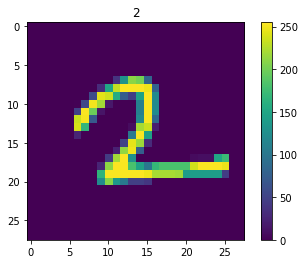

In [53]:
i = 18001
plt.title(str(yt_pred_final[i]))

plt.imshow(np.array(test.iloc[i,0:]).reshape(28,28))
plt.colorbar()

In [ ]:
import time
for i in range(1000,2000):
    plt.title(f'predicted: {yt_pred_final[i]}', size = 50)
    plt.imshow(np.array(test.iloc[i,0:]).reshape(28,28))
    plt.show()
    clear_output(wait =True)
    time.sleep(1.2)

In [ ]:
#train two nns have them check eachother on the final test set: report conflicting results

In [ ]:
yt_pred_final

In [ ]:
#augmentation
#ensemble
#save model at highest test accuracy > 99%
#xavier normal initialization